In [1]:
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

warnings.filterwarnings("ignore")

# 데이터 생성을 위한 함수 정의
def generate_data(num_rows):
    data = []
    start_date = datetime(2023, 11, 1)
    end_date = datetime(2024, 1, 31)
    current_date = start_date

    for _ in range(num_rows):
        temp = round(random.uniform(100, 130), 2)
        speed = round(random.uniform(300, 320), 2)
        count = 0
        
        data.append({
            'Temp': temp,
            'Speed': speed,
            'Time': current_date.strftime("%Y-%m-%d %H:%M:%S"),
            'Count': count
        })
        
        current_date += timedelta(hours=1)

    return data

# 데이터 생성
num_rows = int((datetime(2024, 2, 1) - datetime(2023, 11, 1)).total_seconds() / 3600)  # 총 시간대 수
data = generate_data(num_rows)

# 데이터프레임 생성
df = pd.DataFrame(data)

# 드릴이 고장난 시점 설정
failure_date = random.randint(0, num_rows)
df.loc[failure_date:, 'Count'] = df.loc[failure_date:, 'Count'].apply(lambda x: x + 1)

# 데이터프레임 출력
df

,Temp,Speed,Time,Count
0,112.71,300.96,2023-11-01 00:00:00,0
1,106.23,316.30,2023-11-01 01:00:00,0
2,113.45,310.35,2023-11-01 02:00:00,0
3,103.14,312.53,2023-11-01 03:00:00,0
4,122.03,317.21,2023-11-01 04:00:00,0
...,...,...,...,...
2203,110.03,314.42,2024-01-31 19:00:00,1
2204,120.02,306.80,2024-01-31 20:00:00,1
2205,123.36,311.37,2024-01-31 21:00:00,1
2206,116.31,301.87,2024-01-31 22:00:00,1


In [2]:
df["Status"] = df["Count"].values
df["Count"] = 0
a = df["Status"].values.tolist()
np.random.shuffle(a)
df['Status'] = a

In [3]:
for i in range(1, df.shape[0]):
    if df["Status"][i] == 1:
        df['Count'][i] = df["Count"][i-1]+1
    else:
        df["Count"][i] = df["Count"][i-1]

In [4]:
df.to_csv("./test.csv", encoding="utf8", sep="\t", index=False)

In [16]:
X = df[['Temp', 'Speed', 'Count']].values
y = df['Status'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ndArray 형태로 변환
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps), :])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

TIME_STEPS = 24  # 1일치 데이터를 기반으로 예측
X, y = create_dataset(X_scaled, y, TIME_STEPS)

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# LSTM 모델 정의
model = Sequential(
    [
        LSTM(units=64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, activation="tanh"),
        LSTM(units=32, activation="tanh"),
        Dense(1, activation="sigmoid")
    ]
)

model.compile(optimizer='adam', loss='mean_squared_error')

# 모델 학습
model.fit(X_train, y_train, epochs=300, batch_size=16, validation_split=0.2, shuffle=False)

# 모델 평가
train_loss = model.evaluate(X_train, y_train, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Train Loss: {train_loss:.4f}')
print(f'Test Loss: {test_loss:.4f}')

Epoch 1/300
88/88 [==============================] - 4s 20ms/step - loss: 0.1804 - val_loss: 0.1702
Epoch 2/300
88/88 [==============================] - 1s 9ms/step - loss: 0.1672 - val_loss: 0.1697
Epoch 3/300
88/88 [==============================] - 1s 8ms/step - loss: 0.1667 - val_loss: 0.1695
Epoch 4/300
88/88 [==============================] - 1s 8ms/step - loss: 0.1664 - val_loss: 0.1696
Epoch 5/300
88/88 [==============================] - 1s 8ms/step - loss: 0.1661 - val_loss: 0.1699
Epoch 6/300
88/88 [==============================] - 1s 8ms/step - loss: 0.1659 - val_loss: 0.1703
Epoch 7/300
88/88 [==============================] - 1s 8ms/step - loss: 0.1657 - val_loss: 0.1707
Epoch 8/300
88/88 [==============================] - 1s 8ms/step - loss: 0.1654 - val_loss: 0.1710
Epoch 9/300
88/88 [==============================] - 1s 8ms/step - loss: 0.1652 - val_loss: 0.1713
Epoch 10/300
88/88 [==============================] - 1s 8ms/step - loss: 0.1650 - val_loss: 0.1716
Epoch 11

In [21]:
X_train.shape

(1747, 24, 3)

In [25]:
# 예측 결과 출력
for i in range(20):
    result = model.predict(X_test)[i][0]
    if result >= 0.5:
        print(f'Real status: {y_test[i]} -- Predicted status: 1')
    else:
        print(f'Real status: {y_test[i]} -- Predicted status: 0')

14/14 [==============================] - 0s 10ms/step
Real status: 1 -- Predicted status: 0
14/14 [==============================] - 0s 9ms/step
Real status: 0 -- Predicted status: 0
14/14 [==============================] - 0s 8ms/step
Real status: 0 -- Predicted status: 0
14/14 [==============================] - 0s 8ms/step
Real status: 0 -- Predicted status: 0
14/14 [==============================] - 0s 8ms/step
Real status: 0 -- Predicted status: 0
14/14 [==============================] - 0s 8ms/step
Real status: 0 -- Predicted status: 0
14/14 [==============================] - 0s 7ms/step
Real status: 1 -- Predicted status: 0
14/14 [==============================] - 0s 6ms/step
Real status: 0 -- Predicted status: 0
14/14 [==============================] - 0s 6ms/step
Real status: 0 -- Predicted status: 0
14/14 [==============================] - 0s 6ms/step
Real status: 0 -- Predicted status: 0
14/14 [==============================] - 0s 6ms/step
Real status: 0 -- Predicted status: 

In [ ]:
X_train[""]

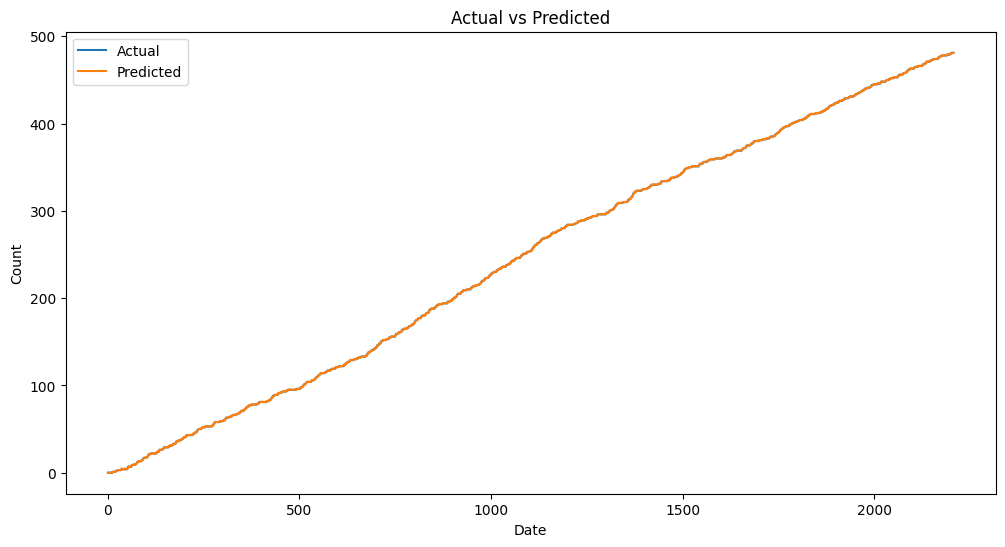

Mean Squared Error: 0.17771819670041236


In [26]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

# SARIMA 모델 학습
model = SARIMAX(df['Count'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 24))  # 예시로 (1,1,1)과 (1,1,1,24)를 사용
result = model.fit()

# 과거 데이터와 예측 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Count'], label='Actual')
plt.plot(df.index, result.fittedvalues, label='Predicted')
plt.title('Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.show()

# 모델 성능 평가
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(df['Count'], result.fittedvalues)
print(f'Mean Squared Error: {mse}')

In [29]:
# 예측할 기간 설정
forecast_periods = 24

# 예측에 사용할 새로운 인덱스 생성
new_index = pd.date_range(start=df.index[-1], periods=forecast_periods+1, freq='H')[1:]

# SARIMA 모델을 사용하여 예측
forecast = result.predict(start=new_index[0], end=new_index[-1])

KeyError: 'The `start` argument could not be matched to a location related to the index of the data.'